In [1]:
import pandas as pd
import anndata
import joblib
import pybedtools
import seaborn as sns
import pyBigWig
import matplotlib.pyplot as plt
import pathlib

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.5
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Load

In [3]:
reptile_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/REPTILE/result/REPTILE_scores.subtype.h5ad'
)
enhancer_hits = pd.Series((reptile_adata.X > 0.5).sum(axis=1).A1,
                          index=reptile_adata.obs_names)
use_dmr = enhancer_hits[enhancer_hits > 3].index

In [4]:
dmr_rate = pd.read_hdf(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5',
    key='Rate').loc[use_dmr].copy()

dmr_bed = pd.read_hdf(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5',
    key='bed').loc[use_dmr].copy()

In [5]:
cluster_order = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/CompareREPTILE/EnhancerDevProfile/SubtypeOrder.txt',
    header=None,
    index_col=0).index

In [6]:
encode_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/study/CompareREPTILE/AnnotateDMRWithENCODE/SubType.DMR.ENCODE_FB_anno.h5ad'
)[use_dmr, :].copy()

encode_adata = encode_adata[:,
                            encode_adata.var.sort_values(
                                ['DataType', 'DevTime', 'Rep']).index].copy()

In [7]:
dmr_corr = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/TotalGeneDMRCorrLoop.0.3.msg'
)
dmr_corr = dmr_corr[dmr_corr['DMR'].isin(use_dmr)].copy()

gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    index_col='gene_id',
    sep='\t')
gene_name_to_id = {n: i for i, n in gene_meta['gene_name'].items()}

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
def get_gene_corr_dmr(gene_name):
    return dmr_corr[dmr_corr['Gene'] == gene_name_to_id[gene_name]]

In [9]:
gene_dmr = get_gene_corr_dmr('Tle4')
gene_dmr_index = pd.Index(gene_dmr['DMR'])

gene_dmr_index.size

156

In [14]:
## Get ATAC signal
atac_bw_dir = pathlib.Path('/home/hanliu/project/mouse_rostral_brain/ATAC/remerge/mCSubType/')
atac_bw_dict = {i.name.split('.')[0]: i for i in atac_bw_dir.glob('*bw')}
ordered_dmr_bed = dmr_bed.loc[gene_dmr_index]

records = {}
for cluster, bw_path in atac_bw_dict.items():
    with pyBigWig.open(str(bw_path)) as bw:
        for dmr_id, (chrom, start, end, _) in ordered_dmr_bed.iterrows():
            records[cluster, dmr_id] = bw.stats(chrom, start, end)[0]
atac_signal = pd.Series(records)

In [13]:
this_rate = dmr_rate.loc[gene_dmr_index]

from sklearn.cluster import MiniBatchKMeans
mbk = MiniBatchKMeans(init='k-means++',
                      n_clusters=3,
                      batch_size=100,
                      n_init=10,
                      max_no_improvement=10,
                      verbose=0,
                      random_state=0)
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

pcs = pca.fit_transform(this_rate.fillna(0.8))
mbk.fit(pcs)

dmr_clusters = pd.Series(mbk.labels_, index=gene_dmr_index)

dmr_cluster_order = this_rate.groupby(dmr_clusters).median().mean(
    axis=1).sort_values().index
dmr_cluster_order = {cluster: i for i, cluster in enumerate(dmr_cluster_order)}

dmr_clusters = dmr_clusters.map(dmr_cluster_order)

ordered_dmr = pd.DataFrame([dmr_clusters,
                            this_rate.mean(axis=1)]).T.sort_values([0,
                                                                    1]).index

In [15]:
fedmr_bed = pybedtools.BedTool(
    '/home/hanliu/ref/inhouse/He_2020_Nature_Mouse_Tissue_Developmental/feDMR_FB.bed'
)

fedmr_ids = pybedtools.BedTool.from_dataframe(
    dmr_bed.loc[ordered_dmr].reset_index().iloc[:, [1, 2, 3, 0]]).intersect(
        fedmr_bed, wa=True, u=True).to_dataframe()['name'].values

is_fedmr = ordered_dmr.isin(fedmr_ids)

In [16]:
atac_signal = atac_signal.unstack().T.loc[ordered_dmr, cluster_order].fillna(0)

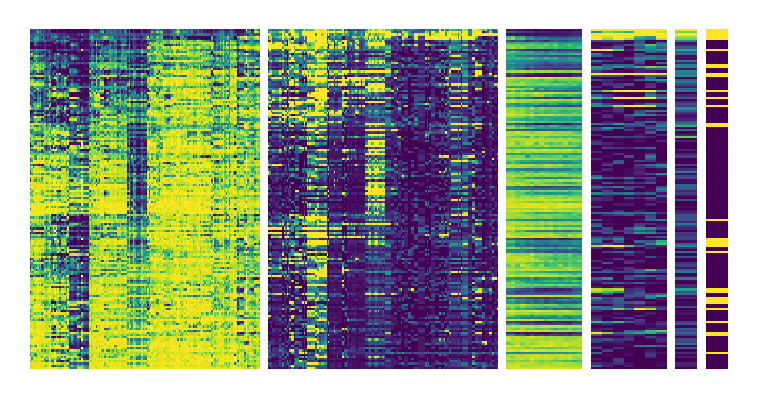

In [19]:
fig = plt.figure(figsize=(3, 1.5), dpi=300)

gs = fig.add_gridspec(10, 91)

adult_cg_ax = fig.add_subplot(gs[:, :30])
adult_atac_ax = fig.add_subplot(gs[:, 31:61])
dev_cg_ax = fig.add_subplot(gs[:, 62:72])
dev_k27_ax = fig.add_subplot(gs[:, 73:83])
adult_k27_ax = fig.add_subplot(gs[:, 84:87])
fedmr_ax = fig.add_subplot(gs[:, 88:91])

ax = adult_cg_ax
ax.imshow(dmr_rate.loc[ordered_dmr, cluster_order], aspect='auto')
ax.axis('off')

ax = adult_atac_ax
ax.imshow(atac_signal, vmin=0, vmax=0.5, aspect='auto')
ax.axis('off')

ax = dev_cg_ax
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.
                                                    var['DataType'] == 'CGN']
ax.imshow(img_data, vmin=0, vmax=1, aspect='auto')
ax.axis('off')

ax = dev_k27_ax
img_data = encode_adata[ordered_dmr, :].X.todense(
)[:, (encode_adata.var['DataType'] == 'H3K27ac') &
  (~encode_adata.var['DevTime'].isin(['P7', 'P21', 'P56']))]
ax.imshow(img_data, vmin=0, vmax=5, aspect='auto')
ax.axis('off')

ax = adult_k27_ax
img_data = encode_adata[ordered_dmr, :].X.todense(
)[:, (encode_adata.var['DataType'] == 'H3K27ac') &
  (encode_adata.var['DevTime'] == 'P56')]
ax.imshow(img_data, vmin=0, vmax=5, aspect='auto')
ax.axis('off')

ax = fedmr_ax
ax.imshow(is_fedmr.astype(int)[:, None], aspect='auto')
ax.axis('off')

fig.savefig('Tle4.pdf')